In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import copy
import h5py
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from biosppy.signals import ecg
from biosppy.signals.tools import filter_signal
from scipy.signal import iirnotch

# IPython imports
from IPython.display import Image
%matplotlib inline

In [2]:
DATA_DIRECTORY = '/mnt/disks/ecg-rest-and-bike-with-trend-tensors/2019-08-13/'
all_sample_ids = [samp[:-4] for samp in os.listdir(DATA_DIRECTORY) if 'hd5' in samp]


def exercise_ecg_by_sample_id(sample_id):
    out = {}
    with h5py.File(os.path.join(DATA_DIRECTORY, f'{sample_id}.hd5'), 'r') as hd5:
        if 'ecg_bike_recovery' not in hd5.keys():
            return
        trends = hd5['ecg_bike_trend']
        rest_start_idx = list(trends['PhaseName']).index(2)
        out['times'] = np.array(list(trends['PhaseTime'])[rest_start_idx:])
        out['hrs'] = np.array(list(trends['HeartRate'])[rest_start_idx:])
        out['loads'] = np.array(list(trends['Load'])[rest_start_idx:])
        out['artifacts'] = np.array(list(trends['Artifact']))                          
        for lead in list(hd5['ecg_bike_recovery'].keys()):
            out[lead] = np.array(hd5['ecg_bike_recovery'][lead])
        out['max_hr'] = list(hd5['continuous']['bike_max_hr'])[0]
        out['resting_hr'] = list(hd5['continuous']['bike_resting_hr'])[0]
        out['max_pred_hr'] = list(hd5['continuous']['bike_max_pred_hr'])[0]
        out['hr_recovery_60s'] = out['max_hr'] - out['hrs'][-1]
        out['hr_increase'] = out['max_hr'] - out['resting_hr']
        out['max_hr_achieved_ratio'] = out['max_hr'] / out['max_pred_hr']
        out['pred_peak_exercise'] = out['max_pred_hr'] - out['resting_hr']
        out['peak_hr_reserve'] = out['max_hr'] / out['pred_peak_exercise']
    return out

In [7]:
all_sample_ids[3]

'3212261'

In [6]:
exercise_ecg_by_sample_id(all_sample_ids[3])

{'times': array([ 3.,  8., 13., 23., 38., 53., 60.], dtype=float32),
 'hrs': array([133., 130., 126., 118., 111., 103., 105.], dtype=float32),
 'loads': array([32.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 'artifacts': array([0.  , 0.  , 0.  , 0.  , 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.11,
        0.05, 0.05, 0.05, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.08,
        0.11, 0.11, 0.11, 0.11, 0.13, 0.17, 0.17, 0.27, 0.27, 0.28, 0.34,
        0.39, 0.39, 0.39, 0.39, 0.41, 0.41, 0.41, 0.43, 0.49, 0.53, 0.69,
        0.73, 0.78, 0.82, 0.94, 0.95, 1.  , 1.01, 0.99, 0.92, 0.76, 0.62,
        0.38, 0.26], dtype=float32),
 'lead_2': array([-18.,  -3., -27., ...,   4.,  -1.,  -2.]),
 'lead_3': array([-13., -19., -19., ...,   2.,  -2.,  -3.]),
 'lead_I': array([-15.,  -5., -32., ...,   5.,   0.,  -2.]),
 'max_hr': 133.0,
 'resting_hr': 76.0,
 'max_pred_hr': 165.0,
 'hr_recovery_60s': 28.0,
 'hr_increase': 57.0,
 'max_hr_achieved_ratio': 0.8060606,
 'pred_peak_exercise': 89.0,
 'peak_hr

[-0.01867339  2.04849205  5.00737592 ... -0.86985916 -0.54559792
 -0.46453261]
[-0.30240198 -0.3834673  -0.30240198 ... -0.22133667 -0.54559792
 -0.18080402]
[-0.14027136  0.10292457 -0.22133667 ... -1.15358775 -1.27518572
 -0.62666323]
[-0.30240198  0.10292457  0.2650552  ... -0.18080402 -0.14027136
 -0.09973871]
[ 0.34549217  3.10559782  5.98747285 ... -0.83161172 -0.54748319
 -0.46630361]
[-0.30394446 -0.34453425 -0.22276488 ... -0.34453425 -0.34453425
 -0.01981594]
[ 0.02077385 -0.01981594 -0.1415853  ... -1.23750961 -1.07515045
 -0.5068934 ]
[-0.1415853   0.18313301  0.14254322 ... -0.22276488 -0.06040572
 -0.1415853 ]
[ 1.03767808  4.04138158  6.55799802 ... -0.66712661 -0.54535484
 -0.38299249]
[-0.38299249 -0.30181132 -0.09885838 ... -0.54535484 -0.3424019
 -0.09885838]
[ 0.02291339 -0.22063014 -0.46417367 ... -1.27598542 -0.78889837
 -0.38299249]
[ 0.02291339  0.26645691  0.10409456 ... -0.18003955 -0.05826779
 -0.05826779]


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


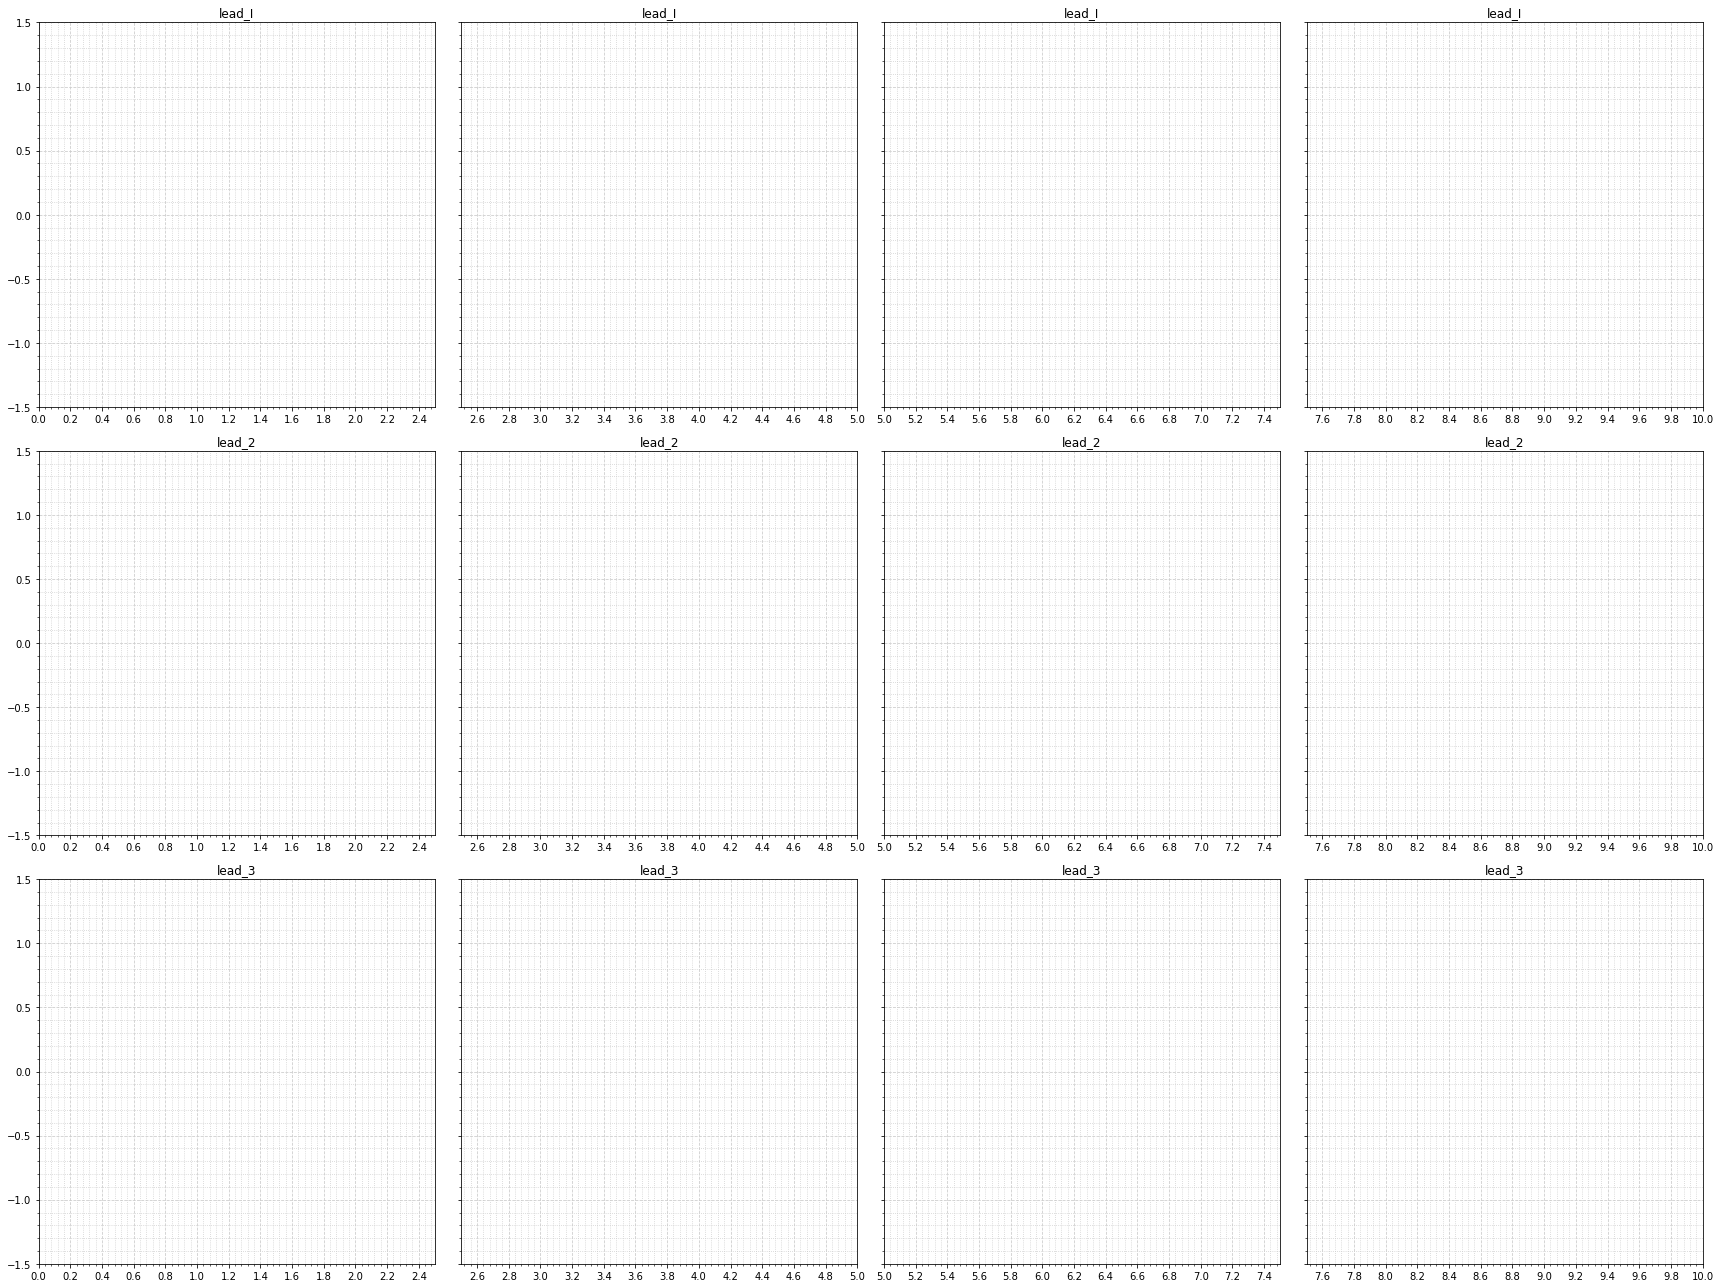

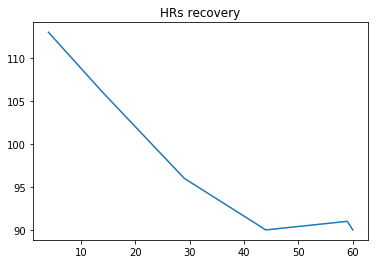

In [8]:
sec_per_box = 0.04
mv_per_box = .1
time_interval = 2.5 #time-interval per plot in seconds. ts_Reference data is in s, voltage measurement is 5 uv per lsb
raw_scale = 0.005 # convert to mV
lead_mapping=np.array([['strip_I','strip_aVR', 'strip_V1', 'strip_V4'],
              ['strip_II','strip_aVL', 'strip_V2', 'strip_V5'],
              ['strip_III','strip_aVF', 'strip_V3', 'strip_V6'],
             ])


def plot_resting_ecg(leads):
    fig, ax = plt.subplots(nrows=3, ncols=4, sharey='row', figsize=(24,18), tight_layout=True)
    for i in range(0,3):
        for j in range(0,4):
            lead_name = ['lead_I', 'lead_2', 'lead_3'][i]
            lead = leads[i][int(j * time_interval * 500): int((j + 1) * 500 * time_interval)]
            print(lead)
            ax[i,j].set_xlim(j*time_interval,(j+1)*time_interval)
            ax[i,j].set_ylim(-1.5, 1.5) #-1.5mV -> 1.5mV
            ax[i,j].xaxis.set_major_locator(MultipleLocator(0.2)) #major grids at every .2sec = 5 * 0.04 sec
            ax[i,j].yaxis.set_major_locator(MultipleLocator(0.5))  #major grids at every .5mV 

            ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(5))
            ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(5))

            ax[i,j].grid(which='major', color='#CCCCCC', linestyle='--')
            ax[i,j].grid(which='minor', color='#CCCCCC', linestyle=':')

            #normalize data in muv
#             ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['filtered']], color='green')
#             ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['raw']], color='red')
            #ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['filtered_1']], color = 'black')
            #ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['filtered_2']], color = 'orange')
            ax[i,j].set_title(lead_name)
    plt.show()

def plot_exercise_ecg(sample_id):
    out = exercise_ecg_by_sample_id(sample_id)
    leads = np.array([out['lead_I'], out['lead_2'], out['lead_3']])
    leads -= leads.mean(axis=1)[: ,np.newaxis]
    leads /= leads.std(axis=1)[: ,np.newaxis]
    plot_resting_ecg(leads[:, :500 * 10])
    plt.plot(out['times'], out['hrs'])
    plt.title('HRs recovery')
    plt.show()
    
plot_exercise_ecg(all_sample_ids[1])

In [ ]:
all_outs = []
for i, s in enumerate(all_sample_ids):
    out = exercise_ecg_by_sample_id(s)
    if out:
        all_outs.append(out)
all_metrics_df = pd.DataFrame(all_outs)

In [38]:
all_metrics_df = pd.DataFrame(all_outs)

In [40]:
all_metrics_df

,artifacts,hr_increase,hr_recovery_60s,hrs,lead_2,lead_3,lead_I,loads,max_hr,max_hr_achieved_ratio,max_pred_hr,peak_hr_reserve,pred_peak_exercise,resting_hr,times
0,"[0.35, 0.44, 0.44, 0.38, 0.39, 0.43, 0.48, 0.4...",40.0,27.0,"[113.0, 106.0, 96.0, 90.0, 91.0, 90.0]","[10.0, 78.0, 149.0, 184.0, 153.0, 100.0, 20.0,...","[27.0, 101.0, 163.0, 178.0, 144.0, 79.0, 11.0,...","[1.0, 52.0, 125.0, 177.0, 162.0, 120.0, 46.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",117.0,0.696429,168.0,1.285714,91.0,77.0,"[4.0, 14.0, 29.0, 44.0, 59.0, 60.0]"
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05, 0.1...",12.0,4.0,"[94.0, 90.0, 95.0, 92.0, 94.0, 94.0]","[18.0, 23.0, 19.0, 6.0, 1.0, 0.0, -7.0, -10.0,...","[23.0, 25.0, 17.0, 9.0, 2.0, -6.0, -10.0, -7.0...","[17.0, 24.0, 24.0, 11.0, 7.0, 5.0, -8.0, -13.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",98.0,0.612500,160.0,1.324324,74.0,86.0,"[4.0, 14.0, 29.0, 44.0, 59.0, 60.0]"
2,"[0.0, 0.0, 0.0, 0.0, 0.06, 0.06, 0.06, 0.06, 0...",57.0,28.0,"[133.0, 130.0, 126.0, 118.0, 111.0, 103.0, 105.0]","[-18.0, -3.0, -27.0, -17.0, -20.0, -11.0, 0.0,...","[-13.0, -19.0, -19.0, -16.0, -20.0, -8.0, -2.0...","[-15.0, -5.0, -32.0, -16.0, -18.0, -16.0, -3.0...","[32.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",133.0,0.806061,165.0,1.494382,89.0,76.0,"[3.0, 8.0, 13.0, 23.0, 38.0, 53.0, 60.0]"
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56.0,36.0,"[139.0, 136.0, 118.0, 111.0, 105.0, 103.0]","[-94.0, -50.0, 67.0, 221.0, 341.0, 294.0, 74.0...","[-80.0, -19.0, 121.0, 275.0, 337.0, 226.0, 45....","[-93.0, -68.0, 22.0, 172.0, 321.0, 325.0, 139....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",139.0,0.803468,173.0,1.544444,90.0,83.0,"[5.0, 10.0, 25.0, 40.0, 55.0, 60.0]"
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42.0,33.0,"[123.0, 120.0, 112.0, 101.0, 96.0, 91.0, 90.0]","[36.0, 33.0, 32.0, 35.0, 33.0, 32.0, 33.0, 13....","[37.0, 34.0, 29.0, 36.0, 24.0, 34.0, 37.0, 14....","[39.0, 35.0, 35.0, 30.0, 37.0, 23.0, 30.0, 26....","[30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",123.0,0.698864,176.0,1.294737,95.0,81.0,"[4.0, 9.0, 14.0, 29.0, 44.0, 59.0, 60.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",36.0,29.0,"[87.0, 95.0, 90.0, 76.0, 72.0, 67.0, 66.0]","[-3.0, 8.0, 9.0, 16.0, 10.0, -2.0, -5.0, -3.0,...","[-4.0, 8.0, 10.0, 17.0, 8.0, -3.0, -7.0, -1.0,...","[-5.0, 2.0, 7.0, 11.0, 13.0, 3.0, -3.0, -6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",95.0,0.582822,163.0,0.913462,104.0,59.0,"[4.0, 14.0, 22.0, 29.0, 44.0, 59.0, 60.0]"
6,"[0.1, 0.1, 0.1, 0.15, 0.2, 0.34, 0.39, 0.49, 0...",37.0,22.0,"[103.0, 101.0, 99.0, 92.0, 88.0, 83.0, 82.0]","[10.0, 4.0, 1.0, 0.0, -1.0, -5.0, -4.0, -8.0, ...","[9.0, 2.0, 0.0, 2.0, -5.0, -5.0, -4.0, -12.0, ...","[13.0, 7.0, 1.0, -1.0, 2.0, -6.0, -4.0, -5.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",104.0,0.641975,162.0,1.094737,95.0,67.0,"[4.0, 8.0, 14.0, 29.0, 44.0, 59.0, 60.0]"
7,"[0.0, 0.0, 0.0, 0.06, 0.06, 0.06, 0.06, 0.06, ...",46.0,30.0,"[108.0, 106.0, 100.0, 96.0, 90.0, 80.0, 80.0]","[-7.0, -1.0, 21.0, 12.0, 30.0, 36.0, 35.0, 37....","[0.0, 7.0, 13.0, 11.0, 28.0, 34.0, 43.0, 33.0,...","[-6.0, 3.0, 21.0, 13.0, 20.0, 30.0, 29.0, 44.0...","[30.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",110.0,0.617977,178.0,0.964912,114.0,64.0,"[4.0, 9.0, 14.0, 29.0, 44.0, 59.0, 60.0]"
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",34.0,12.0,"[126.0, 127.0, 127.0, 122.0, 121.0, 122.0]","[-19.0, -13.0, -14.0, -11.0, 6.0, 8.0, 11.0, 8...","[-17.0, -15.0, -14.0, -5.0, 6.0, 9.0, 10.0, 8....","[-14.0, -13.0, -15.0, -14.0, 2.0, 6.0, 11.0, 8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",134.0,0.802395,167.0,2.000000,67.0,100.0,"[4.0, 9.0, 24.0, 39.0, 54.0, 60.0]"
9,"[0.05, 0.05, 0.05, 0.14, 0.19, 0.33, 0.48, 0.5...",29.0,25.0,"[100.0, 92.0, 86.0, 81.0, 75.0, 75.0]","[6.0, 50.0, 72.0, 68.0, 25.0, 10.0, -3.0, 6.0,...","[19.0, 65.0, 77.0, 49.0, 23.0, 1.0, 4.0, 4.0, ...","[-3.0, 33.0, 71.0, 79.0, 32.0, 19.0, -4.0, 9.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",100.0,0.641026,156.0,1.176471,85.0,71.0,"[4.0, 14.0, 29.0, 44.0, 59.0, 60.0]"


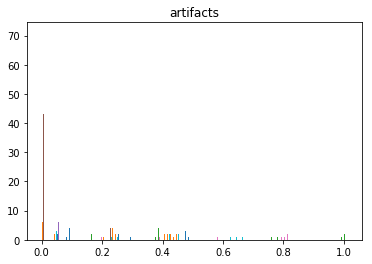

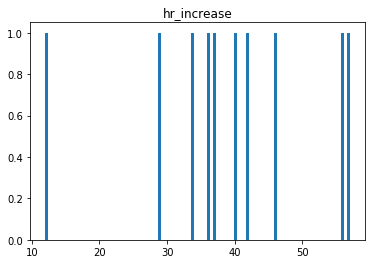

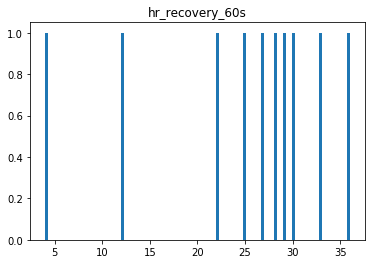

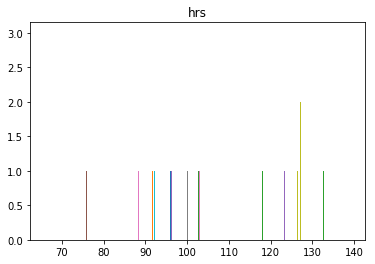

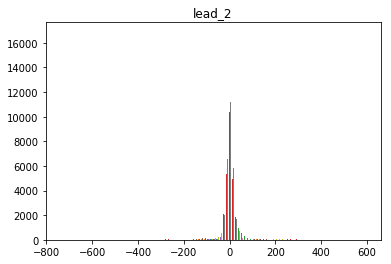

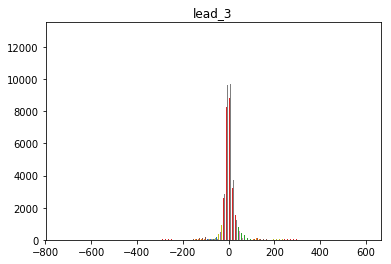

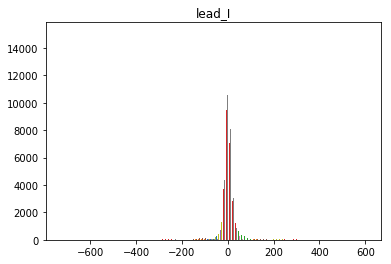

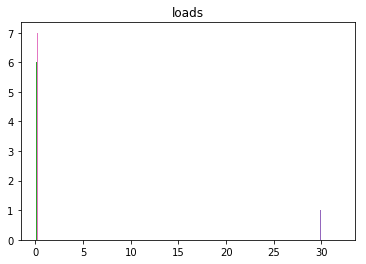

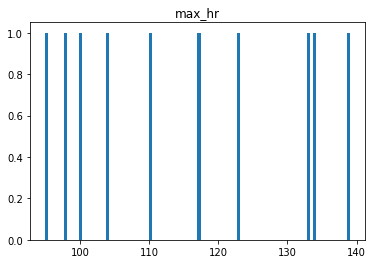

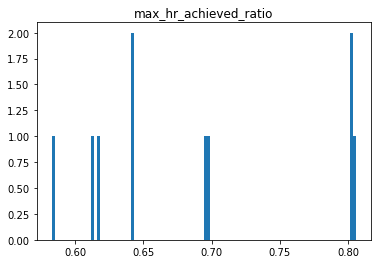

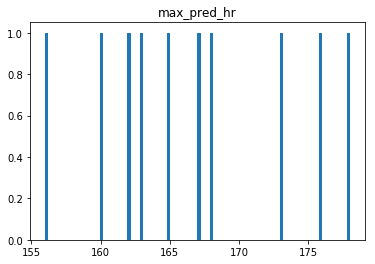

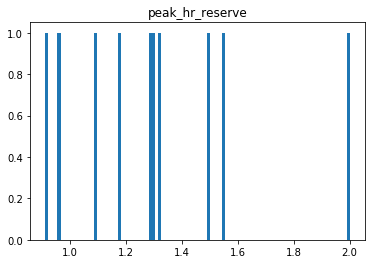

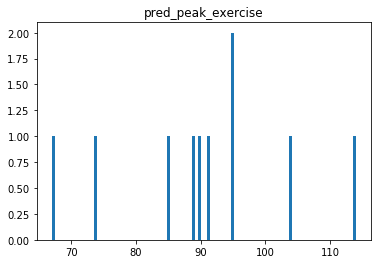

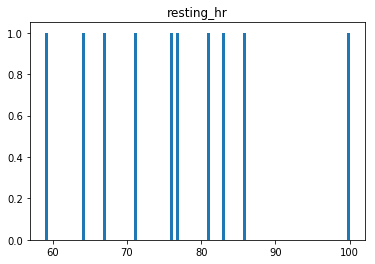

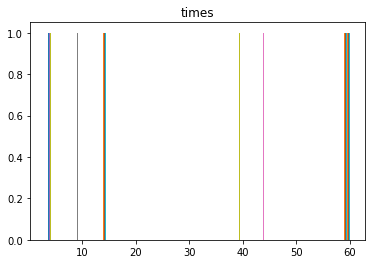

In [39]:
# for col in all_metrics_df.columns:
#     plt.hist(all_metrics_df[col], bins=100)
#     plt.title(col)
#     plt.show()

In [41]:
all_metrics_df.mean()

hr_increase               38.900000
hr_recovery_60s           24.600000
max_hr                   115.300000
max_hr_achieved_ratio      0.690352
max_pred_hr              166.800000
peak_hr_reserve            1.309318
pred_peak_exercise        90.400000
resting_hr                76.400000
dtype: float64

In [42]:
all_metrics_df.std()

hr_increase              13.076272
hr_recovery_60s           9.754771
max_hr                   16.289397
max_hr_achieved_ratio     0.085947
max_pred_hr               7.099296
peak_hr_reserve           0.317382
pred_peak_exercise       13.467657
resting_hr               11.964763
dtype: float64

In [44]:
all_metrics_df.columns

Index(['artifacts', 'hr_increase', 'hr_recovery_60s', 'hrs', 'lead_2',
       'lead_3', 'lead_I', 'loads', 'max_hr', 'max_hr_achieved_ratio',
       'max_pred_hr', 'peak_hr_reserve', 'pred_peak_exercise', 'resting_hr',
       'times'],
      dtype='object')